In [37]:
from modsim import *
from numpy import pi
import pandas as pd

In [73]:
radius_disk = 0.5   # meters
mass_disk = 7    # kg
radius_pot = 0.4   # meters
mass_pot = 0.3    # kg
# force = 2.0       # Newtons
force = 2       # Newtons

theta_push = 0.5  # radians
theta_test = 1.5 # radians
theta_target = pi # radians

In [74]:
I_disk = mass_disk * radius_disk**2 / 2
I_pot = mass_pot * radius_pot**2
I_total = I_disk + I_pot

In [75]:
torque_friction = 0.3 # Newton-meters

In [99]:
params = Params(radius_disk=radius_disk,
                mass_disk=mass_disk,
                radius_pot=radius_pot,
                mass_pot=mass_pot,
                force=force,
                theta_push=theta_push,
                theta_test=theta_test,
                theta_target=theta_target,
                I_disk=I_disk,
                I_pot=I_pot,
                I_total=I_total,
                torque_friction=torque_friction)
def make_system(params):
    init = State(theta=0, omega=0)
    system = System(init=init,
                    params=params,
                    t_end=20)
    return system
system = make_system(params)
system

namespace(init=theta    0
               omega    0
               Name: state, dtype: int64,
          params=namespace(radius_disk=0.5,
                           mass_disk=7,
                           radius_pot=0.4,
                           mass_pot=0.3,
                           force=2,
                           theta_push=0.5,
                           theta_test=1.5,
                           theta_target=3.141592653589793,
                           I_disk=0.875,
                           I_pot=0.04800000000000001,
                           I_total=0.923,
                           torque_friction=0.3),
          t_end=20)

In [100]:
def slope_func(t, state, system):
    theta, omega = state
    radius_disk, force = system.params.radius_disk, system.params.force
    I_total = system.params.I_total
    torque_friction = system.params.torque_friction
    torque = radius_disk * force - torque_friction
    alpha = torque / I_total
    return omega, alpha

In [101]:
slope_func(0, system.init, system)

(0, 0.7583965330444203)

In [102]:
def event_func1(t, state, system):
    theta, omega = state
    return theta - system.params.theta_push

In [103]:
event_func1(0, system.init, system)

-0.5

In [104]:
results1, details1 = run_solve_ivp(system, slope_func, events=event_func1)
details1.message

'A termination event occurred.'

In [105]:
results1.tail()

,theta,omega
1.102359,0.46080,0.836025
1.113842,0.47045,0.844734
1.125325,0.48020,0.853442
1.136808,0.49005,0.862151
1.148291,0.50000,0.870860


In [106]:
t_2 = results1.index[-1]
init2 = results1.iloc[-1]

In [107]:
system2 = system.set(init=init2, t_0=t_2, params=params.set(force=0))
system2

namespace(init=theta    0.50000
               omega    0.87086
               Name: 1.1482906550919196, dtype: float64,
          params=namespace(radius_disk=0.5,
                           mass_disk=7,
                           radius_pot=0.4,
                           mass_pot=0.3,
                           force=0,
                           theta_push=0.5,
                           theta_test=1.5,
                           theta_target=3.141592653589793,
                           I_disk=0.875,
                           I_pot=0.04800000000000001,
                           I_total=0.923,
                           torque_friction=0.3),
          t_end=20,
          t_0=np.float64(1.1482906550919196))

In [108]:
def event_func2(t, state, system):
    theta, omega = state
    return omega

In [109]:
event_func2(0, system2.init, system2)

0.8708596517490182

In [110]:
results2, details2 = run_solve_ivp(system2, slope_func, events=event_func2)
details2.message

'A termination event occurred.'

In [111]:
results = pd.concat([results1, results2])

In [112]:
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-2.220446e-16


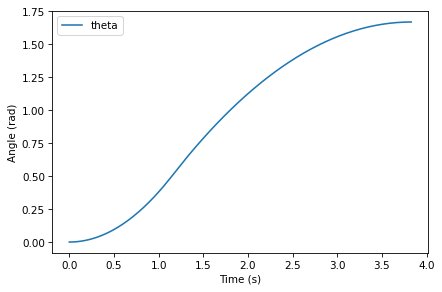

In [113]:
results.theta.plot()
decorate(xlabel='Time (s)',ylabel='Angle (rad)')

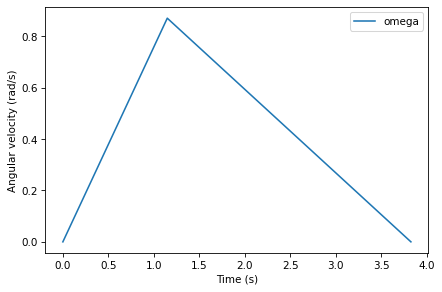

In [114]:
results.omega.plot()
decorate(xlabel='Time (s)',ylabel='Angular velocity (rad/s)')

In [124]:
def run_two_phases(force, torque_friction, system):
    # put the specified parameters into the system object
    system_1 = system.set(params=params.set(
                    force=force, 
                    torque_friction=torque_friction)
                )
    # run phase1
    results1, details1 = run_solve_ivp(system_1, slope_func, events=event_func1)
 
    # get the final state of phase1
    t_2 = results1.index[-1]
    init2 = results1.iloc[-1]
 
    # set the initial conditions for phase2
    system_2 = system_1.set(init=init2, t_0=t_2, params=params.set(force=0,torque_friction=torque_friction))

    # run phase2
    results2, details2 = run_solve_ivp(system_2, slope_func, events=event_func2)
 
    # combine the results
    results = pd.concat([results1, results2])
    return results

In [125]:
results = run_two_phases(2, 0.3, system)

In [126]:
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-2.220446e-16


In [127]:
def error_func1(torque_friction, system):
    force = system.params.force
    results = run_two_phases(force, torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(torque_friction, theta_final)
    return theta_final - system.params.theta_test


In [128]:
guess1 = 0.3
error_func1(guess1, system)

0.3 1.666666666666669


np.float64(0.16666666666666896)

In [129]:
guess2 = 0.4
error_func1(guess2, system)

0.4 1.2499999999999996


np.float64(-0.25000000000000044)

In [131]:
res = root_scalar(error_func1, system, bracket=[0.3, 0.5])

0.3 1.666666666666669
0.3 1.666666666666669
0.5 1.0000000000000016
0.35000000000000064 1.4285714285714257
0.3350000000000002 1.492537313432838
0.3333250000000007 1.5000375009375202
0.3333416662510007 1.4999625028078805


In [132]:
actual_fraction = res.root
actual_fraction

0.3333416662510007

In [138]:
from matplotlib.patches import Circle
from matplotlib.pyplot import gca, axis
def draw_func(t, state):
    theta, omega = state
    # draw a circle for the table
    table = Circle((0, 0), radius_disk)
    gca().add_patch(table)

    # draw a circle for the teapot
    center = pol2cart(theta, radius_pot)
    teapot = Circle(center, 0.05, color='C1')
    gca().add_patch(teapot)
    axis('equal')



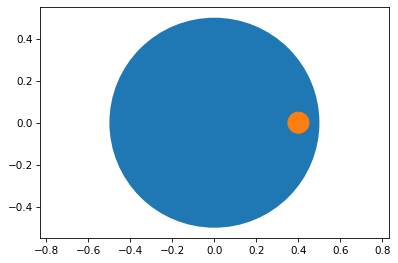

In [140]:
draw_func(0, system.init)

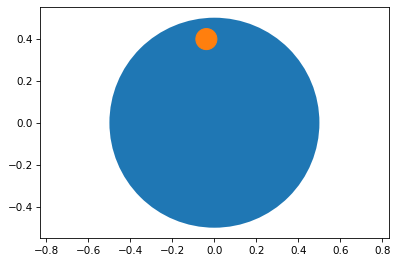

In [143]:
animate(results, draw_func)

In [144]:
# Exercise 25.1
system3 = make_system(params.set(torque_friction=actual_fraction))
system3

namespace(init=theta    0
               omega    0
               Name: state, dtype: int64,
          params=namespace(radius_disk=0.5,
                           mass_disk=7,
                           radius_pot=0.4,
                           mass_pot=0.3,
                           force=2,
                           theta_push=0.5,
                           theta_test=1.5,
                           theta_target=3.141592653589793,
                           I_disk=0.875,
                           I_pot=0.04800000000000001,
                           I_total=0.923,
                           torque_friction=0.3333416662510007),
          t_end=20)

In [145]:
remaining_angle = theta_target - theta_test
remaining_angle

1.6415926535897931

In [146]:
def error_func2(force, system):
    torque_friction = system.params.torque_friction
    results = run_two_phases(force, torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(force, theta_final)
    return theta_final - system.params.theta_target

In [149]:
system3

namespace(init=theta    0
               omega    0
               Name: state, dtype: int64,
          params=namespace(radius_disk=0.5,
                           mass_disk=7,
                           radius_pot=0.4,
                           mass_pot=0.3,
                           force=2,
                           theta_push=0.5,
                           theta_test=1.5,
                           theta_target=3.141592653589793,
                           I_disk=0.875,
                           I_pot=0.04800000000000001,
                           I_total=0.923,
                           torque_friction=0.3333416662510007),
          t_end=20)

In [150]:
error_func2(2, system3)

2 1.4999625028078805


np.float64(-1.6416301507819127)

In [152]:
res = root_scalar(error_func2, system3, bracket=[1, 10])
res

1 0.7499812514039405
1.0 0.7499812514039405
10.0 7.4998125140393945
4.1888949193181 3.1415926535897896
4.1891043640650665 3.141749733223219


      converged: True
           flag: converged
 function_calls: 4
     iterations: 3
           root: 4.1888949193181
         method: brentq

In [155]:
force_actual = res.root
force_actual

4.1888949193181

In [156]:
system4 = make_system(params.set(force=force_actual, torque_friction=actual_fraction))
system4

namespace(init=theta    0
               omega    0
               Name: state, dtype: int64,
          params=namespace(radius_disk=0.5,
                           mass_disk=7,
                           radius_pot=0.4,
                           mass_pot=0.3,
                           force=4.1888949193181,
                           theta_push=0.5,
                           theta_test=1.5,
                           theta_target=3.141592653589793,
                           I_disk=0.875,
                           I_pot=0.04800000000000001,
                           I_total=0.923,
                           torque_friction=0.3333416662510007),
          t_end=20)

In [157]:
results = run_two_phases(force_actual, actual_fraction, system4)
results.tail()

,theta,omega
4.395717,3.137366,0.055252
4.433965,3.139215,0.041439
4.472212,3.140536,0.027626
4.510460,3.141328,0.013813
4.548707,3.141593,0.000000
